In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [3]:
df=pd.read_csv("./AAPL.csv")

In [193]:
data = pd.DataFrame(df["PriceUSD"])
data['returns'] = np.log(data/data.shift(1))
#data['returns'].iloc[1200:1700].cumsum().apply(np.exp).plot(figsize=(10, 6))

In [140]:
"""
data_train = pd.DataFrame(df["CVX"].iloc[0:1000])
data_train['returns'] = np.log(data_train/data_train.shift(1))
data_train
data_test = pd.DataFrame(df["CVX"].iloc[1000:1700])
data_test['returns'] = np.log(data_test/data_test.shift(1))
data_test
data_train.dropna(inplace=True)
data_test.dropna(inplace=True)
"""
data = pd.DataFrame(df["AAPL"])
data['returns']=np.log(data/data.shift(1))


In [141]:
#data = pd.DataFrame(df["AAPL"].iloc[0:1200])
#data['returns'] = np.log(data/data.shift(1))

In [142]:
data['MA20']=data['AAPL'].rolling(window=20).mean()
#data['MA30']=data['AAPL'].rolling(window=30).mean()
#data['MA50']=data['MSFT'].rolling(window=50).mean()
data['MA90']=data['AAPL'].rolling(window=90).mean()
data['MA131']=data['AAPL'].rolling(window=131).mean()

In [143]:
data.dropna(inplace=True)

In [144]:
data['MA_deriv']=data['MA90']-data['MA90'].shift(1)

In [145]:
data.dropna(inplace=True)
data

,AAPL,returns,MA20,MA90,MA131,MA_deriv
131,17.271646,0.014635,20.161841,22.622923,22.396298,-0.087835
132,17.703738,0.024710,19.875076,22.545883,22.394925,-0.077040
133,17.208578,-0.028368,19.569793,22.459912,22.383360,-0.085971
134,14.124880,-0.197470,19.138572,22.351173,22.346770,-0.108739
135,15.252080,0.076778,18.786121,22.256658,22.314606,-0.094515
...,...,...,...,...,...,...
1705,111.105588,-0.004721,112.096521,104.846807,101.294731,0.146343
1706,113.069597,0.017523,111.848043,104.999939,101.475856,0.153132
1707,112.990248,-0.000702,111.599070,105.151750,101.656976,0.151811
1708,111.611465,-0.012278,111.472599,105.288132,101.831696,0.136381


In [146]:
print(data['MA_deriv'].mean())

0.05236355171346136


In [147]:
data['pfolio_MA_deriv']=1
buf=1
for index, row in data.iterrows():
    data.at[index, 'pfolio_MA_deriv']=buf
    if row["MA_deriv"]<0.01:
        buf=0
    else:
        buf=1

In [148]:
data['ret_MA_deriv']=data['returns']*data['pfolio_MA_deriv']

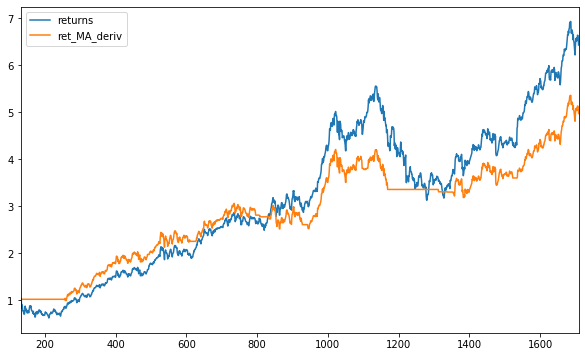

In [149]:
data[['returns', 'ret_MA_deriv']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6))

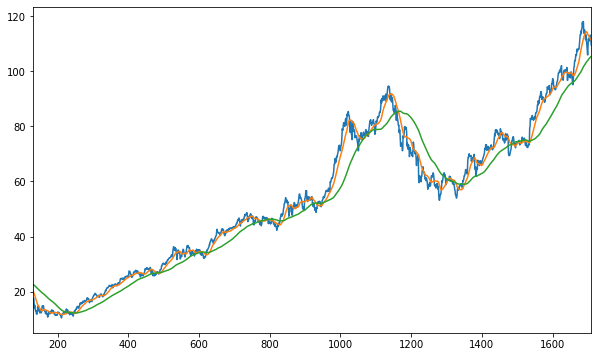

In [150]:
data['AAPL'].plot(figsize=(10, 6))
data['MA20'].plot()
data['MA90'].plot()
plt.show()

In [151]:
data['ret_MA_deriv'].cumsum().apply(np.exp).iloc[-1]

4.972467471795801

In [246]:
def compute_ret_MA(df, stock):
    res=0
    best_MA=0
    for i in range(10,100):
        data = pd.DataFrame(df[stock].iloc[2600:2701])
        data['returns'] = np.log(data/data.shift(1))
        data['MA']=data[stock].rolling(window=i).mean()
        data.dropna(inplace=True)
        data['MA_deriv']=data['MA'].pct_change()
        data.dropna(inplace=True)
        
        data['pfolio_MA_deriv']=1
        buf=1
        for index, row in data.iterrows():
            data.at[index, 'pfolio_MA_deriv']=buf
            if row["MA_deriv"]<0:
                buf=0
            else:
                buf=1
        data['ret_MA_deriv']=data['returns']*data['pfolio_MA_deriv']
       # print(data['ret_MA_deriv'])
        tmp=data['ret_MA_deriv'].cumsum().apply(np.exp).iloc[-1]
        #print(i)
        if (res<tmp):
            res=tmp
            best_MA=i
        #print(i, best_MA, res)
    return res, best_MA

In [5]:
def best_MA(df, stock):
    res=0
    data = pd.DataFrame(df[stock].iloc[200:400])
    data['returns'] = np.log(data/data.shift(1))
    for i in range (101, len(data)):
        for j in range(10,20):
            data['MA']=data[stock].iloc[i-100:i].rolling(window=j).mean()
            data['MA_deriv']=data['MA'].pct_change()
            data['pfolio_MA_deriv']=1
            buf=1
            for index, row in data.iterrows():
                data.at[index, 'pfolio_MA_deriv']=buf
                if row["MA_deriv"]<0:
                    buf=0
                else:
                    buf=1
            data['ret_MA_deriv']=data['returns']*data['pfolio_MA_deriv']
            tmp=data['ret_MA_deriv'].cumsum().apply(np.exp).iloc[-1]
            if (res<tmp):
                res=tmp
                best_MA=i
            data.loc[j,'bestMA']=best_MA            
    return data

In [6]:
datafinal=best_MA(df, 'AAPL')
datafinal.head(130)

,AAPL,returns,MA,MA_deriv,pfolio_MA_deriv,ret_MA_deriv,bestMA
200,12.177784,NaN,NaN,NaN,1,NaN,NaN
201,12.691731,0.041337,NaN,NaN,1,0.041337,NaN
202,12.482391,-0.016632,NaN,NaN,1,-0.016632,NaN
203,12.212671,-0.021845,NaN,NaN,1,-0.021845,NaN
204,12.439454,0.018399,NaN,NaN,1,0.018399,NaN
...,...,...,...,...,...,...,...
325,18.789344,-0.019870,18.675563,-0.001755,0,-0.000000,NaN
326,18.600134,-0.010121,18.638554,-0.001982,0,-0.000000,NaN
327,18.169384,-0.023431,18.586856,-0.002774,0,-0.000000,NaN
328,18.413611,0.013352,18.565456,-0.001151,0,0.000000,NaN


In [247]:
res, MA=compute_ret_MA(df, 'PriceUSD')
print(res, MA)

1.0957574532381025 17


In [284]:
def result_MA(df, MA, stock):
    data = pd.DataFrame(df[stock].iloc[1500:])
    data['returns'] = np.log(data/data.shift(1))
    data['MA']=data[stock].rolling(window=MA).mean()
    #data['MA']=data[stock].iloc[2500:2700].rolling(window=37).mean()
    data.dropna(inplace=True)
    #data['MA_deriv']=data['MA']-data['MA'].shift(2)
    data['MA_deriv']=data['MA'].pct_change()
    data.dropna(inplace=True)    
    buf=1
    for index, row in data.iterrows():
        data.at[index, 'pfolio_MA_deriv']=buf
        if row["MA_deriv"]<0:
            buf=0
        else:
            buf=1
    #data['returns_final']=data['returns'].iloc[500:1700]
    data['ret_MA_deriv']=data['returns']*data['pfolio_MA_deriv']
    print('ret_MA ',data['ret_MA_deriv'].cumsum().apply(np.exp).iloc[-1])
    data[['returns', 'ret_MA_deriv']].cumsum().apply(np.exp).plot(figsize=(10, 6))
    plt.show()    
    data['MA'].plot(figsize=(10,6))
    data[stock].plot()
    plt.show()

ret_MA  65.487870155056


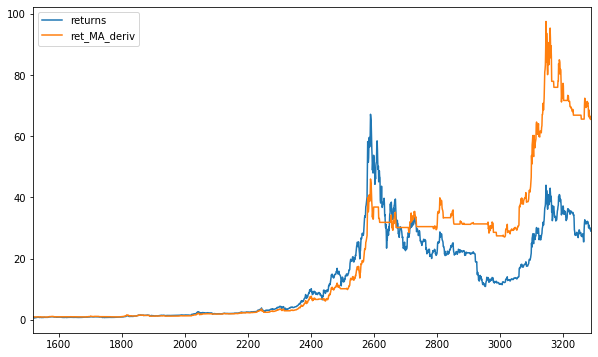

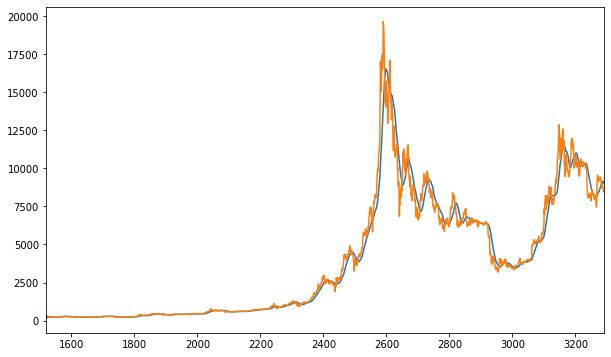

In [285]:
result_MA(df, 19, 'PriceUSD')

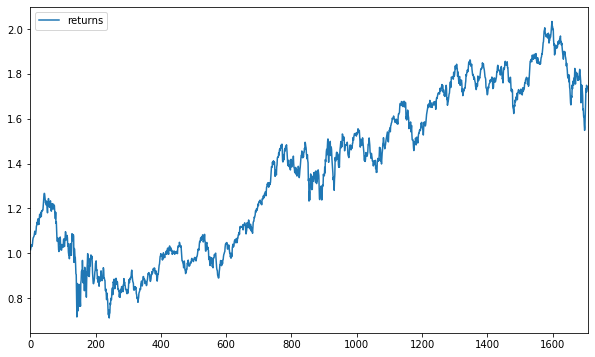

In [373]:
data[['returns']].cumsum().apply(np.exp).plot(figsize=(10, 6))

In [196]:
print(data.loc[2,"PriceUSD"])

0.26846455581531303
